Note: 
In our paper, the efficiency comparison was performed on the CPU. Our code design involves list-based operations, which prevent the use of CUDA acceleration. To enable CUDA acceleration, an M×M coefficient matrix can be constructed, where M represents the number of collocation points. Specifically, each row of this matrix stores the coefficients (encompassing all collocation points) corresponding to a reference point. However, only N coefficients per row are nonzero, where N is the number of supporting points. While this approach facilitates CUDA acceleration, it substantially increases memory consumption. Overall, theoretically, the LSFD method is more efficient than the AD method.

Reference：

[1]Xiao Y, Yang LM, Du YJ, et al. Radial basis function-differential quadrature-based physics-informed neural network for steady incompressible flows. Physics of Fluids, 2023, 35(7):073607. 

[2]Xiao Y, Yang LM, Shu C, et al. Least-square finite difference-based physics-informed neural network for steady incompressible flows. Computers & Mathematics with Applications. 2024, 75:33-48.

In [2]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import sys
import os
import numpy as np
import json
import scipy.io
from pyDOE import lhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import pandas
import openturns as ot
from pandas import DataFrame
import xlwt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

C:\Users\Dell\AppData\Local\Temp\ipykernel_1744\174320879.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


In [3]:
np.random.seed(1234)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device = torch.device('cpu')

In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = layers
        self.layer1 = nn.Sequential(nn.Linear(layers[0], layers[1]),nn.Tanh(),nn.BatchNorm1d(layers[1]))
        self.layer2 = nn.Sequential(nn.Linear(layers[1], layers[2]),nn.Tanh(),nn.BatchNorm1d(layers[2]))
        self.layer3 = nn.Sequential(nn.Linear(layers[2], layers[3]),nn.Tanh(),nn.BatchNorm1d(layers[3]))
        self.layer4 = nn.Sequential(nn.Linear(layers[3], layers[4]),nn.Tanh(),nn.BatchNorm1d(layers[4]))
        self.layer5 = nn.Sequential(nn.Linear(layers[4], layers[5]),nn.Tanh(),nn.BatchNorm1d(layers[4]))
        self.layer6 = nn.Sequential(nn.Linear(layers[5], layers[6]),nn.Tanh(),nn.BatchNorm1d(layers[4]))
        self.layer9 = nn.Sequential(nn.Linear(layers[8], layers[9]))

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer9(x)
        return x

In [ ]:
class PINNS(DNN):
    def __init__(self, layers, X_f, L, M1,M2,M3,M4,N):
        super(PINNS, self).__init__(layers)
        
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad = True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad = True).float().to(device)
        self.M1 = torch.tensor(M1).float().to(device)
        self.M2 = torch.tensor(M2).float().to(device)
        self.M3 = torch.tensor(M3).float().to(device)
        self.M4 = torch.tensor(M4).float().to(device)
        self.N = N
        self.L1 = L
        self.dnn = DNN(layers).to(device)
        self.epoch = 0
        
        #u（x，t）
    def u_model(self, x, t):
        u = self.dnn(torch.cat([x, t], dim = 1))
        return u
    
        # AD Method: f（x，t）
    def f_model(self, x, y):
        u_f = self.u_model(x, y)
        u = u_f[:, 0:1]
        v = u_f[:, 1:2]
        p = u_f[:, 2:3]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        v_y = torch.autograd.grad(
            v, y, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]

        p_x = torch.autograd.grad(
            p, x, 
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
        )[0]
        p_y = torch.autograd.grad(
            p, y, 
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
        )[0]

        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        v_yy = torch.autograd.grad(
            v_y, y, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_yy = torch.autograd.grad(
            u_y, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u * u_x + v * u_y - (1.0/1000) * (u_xx + u_yy) + p_x
        g = u * v_x + v * v_y - (1.0/1000) * (v_xx + v_yy) + p_y
        h = u_x + v_y
        return f, g, h

        # LSFD Method: f（x，t）
    def f1_model(self, x, t):
        u = self.u_model(x, t)
        u11 = u[:, 0:1]
        v11 = u[:, 1:2]
        p11 = u[:, 2:3]
        Mx = My = self.N
        deltax = 1/(Mx-1)
        deltay = 1/(My-1)

        u_x1 = torch.squeeze(torch.bmm(self.M1,u11[self.L1]-torch.unsqueeze(u11, 2)),2).reshape(My,Mx)  ## u11[self.L1] involves list-based operations, which prevent the use of CUDA acceleration.
        u_y1 = torch.squeeze(torch.bmm(self.M2,u11[self.L1]-torch.unsqueeze(u11, 2)),2).reshape(My,Mx)
        u_xx1 = torch.squeeze(torch.bmm(self.M3,u11[self.L1]-torch.unsqueeze(u11, 2)),2).reshape(My,Mx)
        u_yy1 = torch.squeeze(torch.bmm(self.M4,u11[self.L1]-torch.unsqueeze(u11, 2)),2).reshape(My,Mx)
        v_x1 = torch.squeeze(torch.bmm(self.M1,v11[self.L1]-torch.unsqueeze(v11, 2)),2).reshape(My,Mx)
        v_y1 = torch.squeeze(torch.bmm(self.M2,v11[self.L1]-torch.unsqueeze(v11, 2)),2).reshape(My,Mx)
        v_xx1 = torch.squeeze(torch.bmm(self.M3,v11[self.L1]-torch.unsqueeze(v11, 2)),2).reshape(My,Mx)
        v_yy1 = torch.squeeze(torch.bmm(self.M4,v11[self.L1]-torch.unsqueeze(v11, 2)),2).reshape(My,Mx)
        p_x1 = torch.squeeze(torch.bmm(self.M1,p11[self.L1]-torch.unsqueeze(p11, 2)),2).reshape(My,Mx)
        p_y1 = torch.squeeze(torch.bmm(self.M2,p11[self.L1]-torch.unsqueeze(p11, 2)),2).reshape(My,Mx)

        u_11 = u11.reshape(My,Mx)
        v_11 = v11.reshape(My,Mx)
        p_11 = p11.reshape(My,Mx)

        u_11[0,:] = u_11[:,0] = u_11[:,-1] = 0.0
        u_11[-1,:] = 1.0 
        v_11[-1,:] = v_11[0,:] = v_11[:,0] = v_11[:,-1] = 0.0 
        
        u_x2 = (u_11[1:My-1,2:Mx] - u_11[1:My-1,0:Mx-2])/(2*deltax)
        u_y2 = (u_11[2:My,1:Mx-1] - u_11[0:My-2,1:Mx-1])/(2*deltay)
        u_xx2 = (u_11[1:My-1,2:Mx] + u_11[1:My-1,0:Mx-2] - 2.0*u_11[1:My-1,1:Mx-1])/(deltax**2)
        u_yy2 = (u_11[2:My,1:Mx-1] + u_11[0:My-2,1:Mx-1] - 2.0*u_11[1:My-1,1:Mx-1])/(deltay**2)
        v_x2 = (v_11[1:My-1,2:Mx] - v_11[1:My-1,0:Mx-2])/(2*deltax)
        v_y2 = (v_11[2:My,1:Mx-1] - v_11[0:My-2,1:Mx-1])/(2*deltay)
        v_xx2 = (v_11[1:My-1,2:Mx] + v_11[1:My-1,0:Mx-2] - 2.0*v_11[1:My-1,1:Mx-1])/(deltax**2)
        v_yy2 = (v_11[2:My,1:Mx-1] + v_11[0:My-2,1:Mx-1] - 2.0*v_11[1:My-1,1:Mx-1])/(deltay**2)
        p_x2 = (p_11[1:My-1,2:Mx] - p_11[1:My-1,0:Mx-2])/(2*deltax)
        p_y2 = (p_11[2:My,1:Mx-1] - p_11[0:My-2,1:Mx-1])/(2*deltay)
        
        u_x2[2:My-4,2:Mx-4] = u_x1[3:My-3,3:Mx-3] 
        u_y2[2:My-4,2:Mx-4] = u_y1[3:My-3,3:Mx-3] 
        u_xx2[2:My-4,2:Mx-4] = u_xx1[3:My-3,3:Mx-3] 
        u_yy2[2:My-4,2:Mx-4] = u_yy1[3:My-3,3:Mx-3] 
        v_x2[2:My-4,2:Mx-4] = v_x1[3:My-3,3:Mx-3] 
        v_y2[2:My-4,2:Mx-4] = v_y1[3:My-3,3:Mx-3] 
        v_xx2[2:My-4,2:Mx-4] = v_xx1[3:My-3,3:Mx-3] 
        v_yy2[2:My-4,2:Mx-4] = v_yy1[3:My-3,3:Mx-3]  
        p_x2[2:My-4,2:Mx-4] = p_x1[3:My-3,3:Mx-3] 
        p_y2[2:My-4,2:Mx-4] = p_y1[3:My-3,3:Mx-3]

        f = u_x2 + v_y2
        g = u_11[1:My-1,1:Mx-1]*u_x2 + v_11[1:My-1,1:Mx-1]*u_y2 + p_x2 - (1/1000)*(u_xx2 + u_yy2)
        h = u_11[1:My-1,1:Mx-1]*v_x2 + v_11[1:My-1,1:Mx-1]*v_y2 + p_y2 - (1/1000)*(v_xx2 + v_yy2)

        return f, g, h

        #Loss Function
    def loss_fun(self):
        self.optimizer.zero_grad()
        f_net, g_net, h_net = self.f1_model(self.x_f, self.t_f)
        loss = torch.mean(h_net **2) + torch.mean(f_net **2) + torch.mean(g_net **2)

        loss.backward()

        self.epoch += 1
        if self.epoch % 100 ==0:
            print('Epoch:{}, loss:{:5e}'.\
                format(self.epoch, loss.item()))
        
        return loss
    
        # optimizers
    def Adam_train(self, l_r, epochs):
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=l_r, betas=(0.9, 0.999), eps=1e-08)
        for i in range(epochs):
            self.dnn.train()
            self.optimizer.step(self.loss_fun)

    def SGD_train(self, l_r, epochs):
        optimizer = torch.optim.SGD(self.dnn.parameters(), lr=l_r, momentum=0.9)
        for i in range(epochs):
            self.dnn.train()
            optimizer.step(self.loss_fun)
        
    def LBFGS_train(self):
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=100000, 
            max_eval=100000, 
            history_size=50,
            tolerance_grad=1e-10, 
            tolerance_change=1.0 * np.finfo(float).eps,    
        )
        self.dnn.train()
        self.optimizer.step(self.loss_fun)

        # Predict
    def predict(self, x, y):
        x = torch.tensor(x, requires_grad = True).float().to(device)
        y = torch.tensor(y, requires_grad = True).float().to(device)
        self.dnn.eval()

        u = self.u_model(x, y)
        u_1 = u[:, 0:1]
        u_2 = u[:, 1:2]
        u_3 = u[:, 2:3]

        return u_1.detach().cpu().numpy(), u_2.detach().cpu().numpy(), u_3.detach().cpu().numpy()

In [ ]:
layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 3]
N = 101 ## Mesh size
x0 = np.linspace(0.0,1.0,N)
y0 = np.linspace(0.0,1.0,N)
X0,T0 = np.meshgrid(x0, y0)
X_f_train1 = np.hstack((X0[3:-3,3:-3].flatten()[:,None], T0[3:-3,3:-3].flatten()[:,None]))

## Uniform Mesh
X_f_train = np.hstack((X0.flatten()[:,None], T0.flatten()[:,None]))

## Halton Sequence, collocation points：151*151
"""
sequence1 = ot.LowDiscrepancySequence(ot.HaltonSequence(2))
d1 = sequence1.generate((N-8)*(N-8))
d1 = 0.95*np.array(d1)+0.025
d1 = np.array(d1)
X0[4:-4,4:-4] = d1[:,0:1].reshape(N-8,N-8)
T0[4:-4,4:-4] = d1[:,1:2].reshape(N-8,N-8)

X_f_train1 = np.hstack((X0[3:-3,3:-3].flatten()[:,None], T0[3:-3,3:-3].flatten()[:,None]))
X_f_train = np.hstack((X0.flatten()[:,None], T0.flatten()[:,None]))
"""
## Harmmersley Sequence, collocation points：101*101
"""
sequence1 = ot.LowDiscrepancySequence(ot.HaltonSequence(1))
d1 = sequence1.generate((N-8)*(N-8))
#d1 = np.array(d1)# Convert a data type to an array
a = np.zeros(((N-8)*(N-8),1))
for i in range((N-8)*(N-8)):
    a[i] = i/((N-8)*(N-8)) 
a = 0.93*np.array(a)+0.035
d1 = 0.93*np.array(d1)+0.035
X0[4:-4,4:-4] = d1.reshape(N-8,N-8)
T0[4:-4,4:-4] = a.reshape(N-8,N-8)
X_f_train1 = np.hstack((X0[3:-3,3:-3].flatten()[:,None], T0[3:-3,3:-3].flatten()[:,None]))
X_f_train = np.hstack((X0.flatten()[:,None], T0.flatten()[:,None]))"""

'\nsequence1 = ot.LowDiscrepancySequence(ot.HaltonSequence(1))\nd1 = sequence1.generate((N-8)*(N-8))\n#d1 = np.array(d1)# Convert a data type to an array\na = np.zeros(((N-8)*(N-8),1))\nfor i in range((N-8)*(N-8)):\n    a[i] = i/((N-8)*(N-8)) \na = 0.93*np.array(a)+0.035\nd1 = 0.93*np.array(d1)+0.035\nX0[4:-4,4:-4] = d1.reshape(N-8,N-8)\nT0[4:-4,4:-4] = a.reshape(N-8,N-8)\nX_f_train1 = np.hstack((X0[3:-3,3:-3].flatten()[:,None], T0[3:-3,3:-3].flatten()[:,None]))\nX_f_train = np.hstack((X0.flatten()[:,None], T0.flatten()[:,None]))'

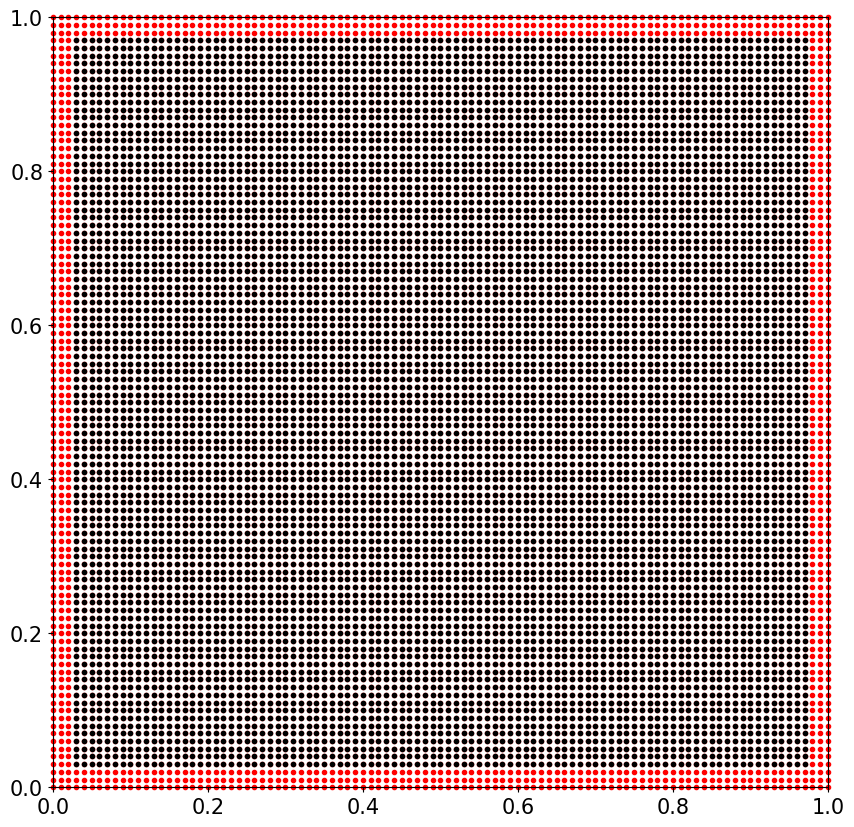

In [14]:
font = {'family': 'Times New Roman',}
font1 = {'family': 'Times New Roman','style': 'italic',}
fig = plt.figure(figsize=(10, 10))
plt.tick_params(labelsize=15)
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.scatter(X_f_train[:,0],X_f_train[:,1],c = 'r',marker='.',clip_on = False)
plt.scatter(X_f_train1[:,0],X_f_train1[:,1],c = 'k',marker='.',clip_on = False)

plt.show()

In [15]:
def Matrix(X_star, N_f, n):
    L = np.zeros((N_f, N_f))
    for i in range(N_f):
        for j in range(N_f):
            L[i,j] = np.sqrt((X_star[j,0] - X_star[i,0])**2 + (X_star[j,1] - X_star[i,1])**2)

    List = []

    for i in range(N_f):
        temp = []
        temp1 = []
        Inf = 100
        LL = L[i,:].tolist()
        for k in range(n+1):
            temp.append(LL.index(min(LL)))
            temp1.append(LL[LL.index(min(LL))])
            LL[LL.index(min(LL))]=Inf
        temp[0], temp[temp1.index(min(temp1))] = temp[temp1.index(min(temp1))], temp[0]
        temp[n], temp[temp1.index(max(temp1))] = temp[temp1.index(max(temp1))], temp[n]
        List.append(temp[1:])

    print(len(List))

    m = 9
    M = np.zeros((N_f,m, n))
    M1 = np.zeros((n,m))

    for i in range(N_f):
        d = np.sqrt((-X_star[i, 0] + X_star[List[i][-1], 0])**2+(-X_star[i, 1] + X_star[List[i][-1], 1])**2)
        D = np.zeros((m,m))
        W = np.zeros((n,n))
        for k in range(n):
            M1[k, 0] = (-X_star[i, 0] + X_star[List[i][k], 0])/d
            D[0,0] = 1/d
            M1[k, 1] = (-X_star[i, 1] + X_star[List[i][k], 1])/d
            D[1,1] = 1/d
            M1[k, 2] = 0.5*((-X_star[i, 0] + X_star[List[i][k], 0])/d)**2
            D[2,2] = 1/d**2
            M1[k, 3] = 0.5*((-X_star[i, 1] + X_star[List[i][k], 1])/d)**2
            D[3,3] = 1/d**2
            M1[k, 4] = (-X_star[i, 0] + X_star[List[i][k], 0])*(-X_star[i, 1] + X_star[List[i][k], 1])/d**2
            D[4,4] = 1/d**2
            M1[k, 5] = ((-X_star[i, 0] + X_star[List[i][k], 0])**3)/6/d**3
            D[5,5] = 1/d**3
            M1[k, 6] = ((-X_star[i, 1] + X_star[List[i][k], 1])**3)/6/d**3
            D[6,6] = 1/d**3
            M1[k, 7] = (0.5*(-X_star[i, 1] + X_star[List[i][k], 1])*(-X_star[i, 0] + X_star[List[i][k], 0])**2)/d**3
            D[7,7] = 1/d**3
            M1[k, 8] = (0.5*(-X_star[i, 0] + X_star[List[i][k], 0])*(-X_star[i, 1] + X_star[List[i][k], 1])**2)/d**3
            D[8,8] = 1/d**3 
            W[k,k] = np.sqrt(4.0/np.pi)*(1-(np.sqrt((-X_star[i, 0] + X_star[List[i][k], 0])**2 + (-X_star[i, 1] + X_star[List[i][k], 1])**2)/d)**2)**4

        M[i,:,:] = np.dot(D,np.dot(np.linalg.inv(np.dot(M1.T, np.dot(W,M1))), np.dot(M1.T,W)))

    return List, M

L1, M = Matrix(X_f_train, X_f_train.shape[0],18)

10201


In [16]:
print(M.shape)
print(X_f_train[:,0:1].shape)
print(X_f_train[:,0:1][L1].shape)
print(len(L1))

(10201, 9, 18)
(10201, 1)
(10201, 18, 1)
10201


In [18]:
layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 3]
model = PINNS(layers, X_f_train, L1, M[:,0:1,:], M[:,1:2,:], M[:,2:3,:], M[:,3:4,:],N)

In [19]:
%%time
                
#开始训练
model.Adam_train(0.001,200000)

Epoch:100, loss:4.602215e-01
Epoch:200, loss:4.775682e-01
Epoch:300, loss:4.538791e-01
Epoch:400, loss:4.276703e-01


KeyboardInterrupt: 

In [ ]:
%%time
                

model.Adam_train(0.0001,100000)

In [ ]:
%%time
               

model.LBFGS_train()

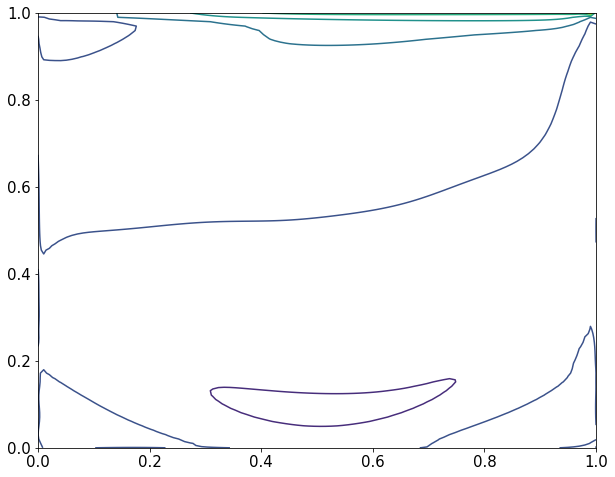

In [ ]:
Mx = My = 100
dx = dy = 1/Mx
#x = np.linspace(0,1,Mx+1)[:,None]
#y = np.linspace(0,1,My+1)[:,None]
#X, Y = np.meshgrid(x[1:Mx+1]-dx/2.0, y[1:My+1]-dy/2.0)
x_star = np.linspace(0, 1, Mx)[:,None]
y_star = np.linspace(0, 1, My)[:,None]
X, Y = np.meshgrid(x_star, y_star)
X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
x_1 = X_star[:,0:1]
y_1 = X_star[:,1:2]     
u_pred, v_pred, p_pred = model.predict(x_1, y_1)
U_pred = u_pred.reshape(Mx,My)
V_pred = v_pred.reshape(Mx,My)
P_pred = p_pred.reshape(Mx,My)
fig = plt.figure(figsize=(10, 8))
plt.tick_params(labelsize=15)
plt.contour(X,Y,U_pred)
plt.show()

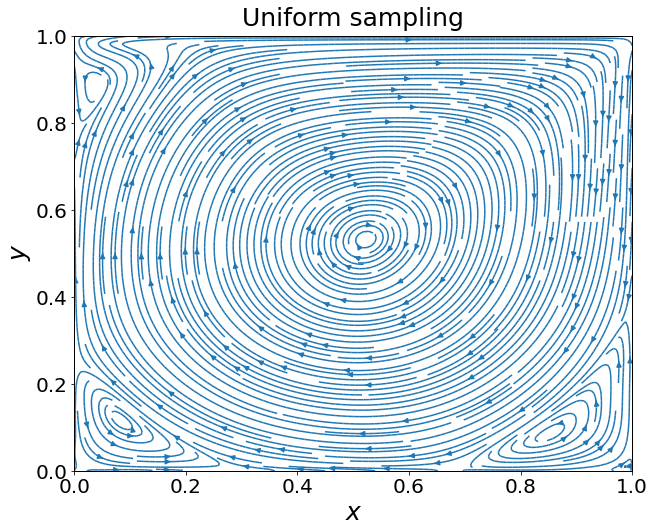

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.streamplot(X,Y,U_pred,V_pred,density=3)
plt.tick_params(labelsize=20)
plt.xlim(0.0,1.0)
plt.xlabel('x', size=25,fontdict = font1)
plt.ylabel('y', size=25,fontdict = font1)
plt.title(r"Uniform Mesh", size = 25, pad =10)
plt.ylim(0.0,1.0)
fig1=plt.gcf()
ax=plt.gca()
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
#plt.savefig('Streamline_1000_Uniform.jpg', format='jpg', dpi=200)
plt.show()

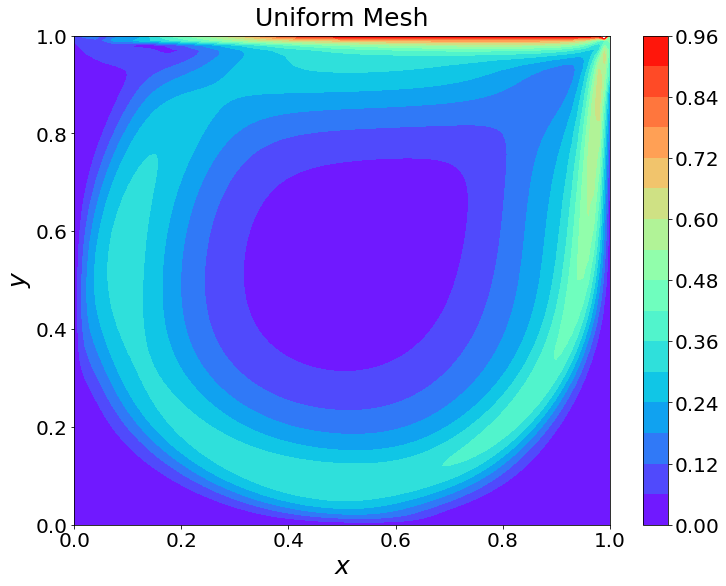

In [ ]:
fig = plt.figure(figsize=(12, 9))
ax = plt.contourf(X,Y,np.sqrt(U_pred**2+V_pred**2), 12,cmap='rainbow',levels=np.linspace(0,0.96,17))
#plt.colorbar(ax)
ax1 = plt.colorbar(ax)
ax1.ax.tick_params(labelsize=20) 
plt.xlabel('x',size=25,fontdict = font1)
plt.ylabel('y',size=25,fontdict = font1)
plt.tick_params(labelsize=20)
plt.title("Uniform Mesh",fontsize = 25,pad=10)
plt.rcParams['font.sans-serif'] = 'Times New Roman'
#plt.savefig('Contouf_1000_Uniform_LSFD.jpg', format='jpg', dpi=200)
plt.show()

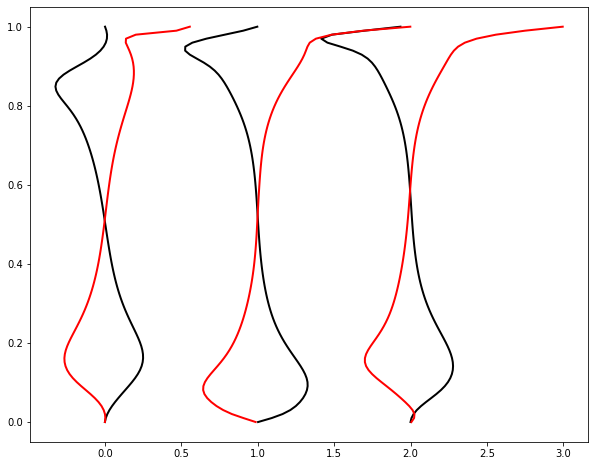

In [133]:
x_11 = np.linspace(0.0, 1.0, 100)[:,None]

y_11 = np.array([0.25]*100)[:,None]
y_22 = np.array([0.5]*100)[:,None]
y_33 = np.array([0.75]*100)[:,None]
u_pred1, v_pred1, p_pred1 = model.predict(x_11, y_11)
u_pred2, v_pred2, p_pred2 = model.predict(x_11, y_22)
u_pred3, v_pred3, p_pred3 = model.predict(x_11, y_33)

u_pred11, v_pred11, p_pred11 = model.predict(y_11, x_11)
u_pred22, v_pred22, p_pred22 = model.predict(y_22, x_11)
u_pred33, v_pred33, p_pred33 = model.predict(y_33, x_11)

fig = plt.figure(figsize=(10, 8))
plt.plot(v_pred1, x_11,"k-",label='Exact',linewidth = 2)
plt.plot(v_pred2+1.0, x_11,"k-",label='Exact',linewidth = 2)
plt.plot(v_pred3+2.0, x_11,"k-",label='Exact',linewidth = 2)

plt.plot(u_pred11, x_11,"r-",label='Exact',linewidth = 2)
plt.plot(u_pred22+1.0, x_11,"r-",label='Exact',linewidth = 2)
plt.plot(u_pred33+2.0, x_11,"r-",label='Exact',linewidth = 2)
plt.show()

(200, 1)


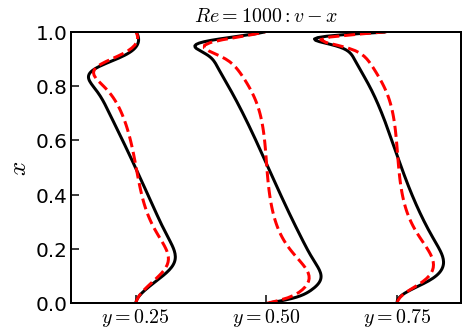

In [ ]:
u_1000 = pandas.read_excel("LBFS-1000-u.xls")
v_1000 = pandas.read_excel("LBFS-1000-v.xls")

u_1000 = np.array(u_1000)
u_1000 = 10*u_1000[:,1:]
v_1000 = np.array(v_1000)
v_1000 = 10*v_1000[:,1:]


x_1 = np.linspace(0.0, 1.0, 201)[:,None]

x_1 = x_1 - 1.0/200/2
x_1 = x_1[1:]
x_1 = x_1.reshape(200,1)
print(x_1.shape)

u1 = u_1000.T
v1 = v_1000.T

v_ex1 = v1[:,49][:,None]
v_ex2 = v1[:,99][:,None]
v_ex3 = v1[:,149][:,None]

u_ex11 = u1[49,:][:,None]
u_ex22 = u1[99,:][:,None]
u_ex33 = u1[149,:][:,None]

import matplotlib
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
plt.ylabel('$x$', size=25,fontdict = font1)
plt.title('$Re=1000: v-x$', size=20,fontdict = font1,pad = 10)
plt.xticks([0.0,1.0,2.0],(["$y = 0.25$","$y = 0.50$","$y = 0.75$"]))
plt.rcParams["font.style"] = 'normal'
plt.tick_params(labelsize=20)
plt.ylim(0.0,1.0)
plt.plot(v_ex1, x_1,"k-",label='CFD',linewidth = 3)
plt.plot(v_ex2+1.0, x_1,"k-",linewidth = 3)
plt.plot(v_ex3+2.0, x_1,"k-",linewidth = 3)
plt.plot(v_pred1, x_11,"r--",label='LSFD-PINN',linewidth = 3)
plt.plot(v_pred2+1.0, x_11,"r--",linewidth = 3)
plt.plot(v_pred3+2.0, x_11,"r--",linewidth = 3)

ax=plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
axes = plt.subplot()
axes.minorticks_on()
axes.tick_params(axis="both", which="major", direction="in", width=1.5, length=8)
axes.tick_params(axis="both", which="minor", direction="in", width=0, length=0) 
#plt.savefig('LSFD_cavity_3200_v_2.png', format='png', dpi=200)
plt.show()
plt.show()

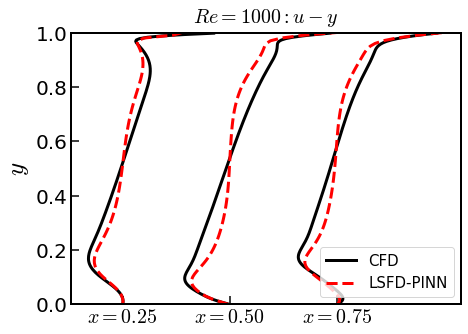

In [ ]:
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
plt.ylabel('$y$', size=25,fontdict = font1)
plt.title('$Re=1000: u-y$', size=20,fontdict = font1,pad = 10)
plt.xticks([0.0,1.0,2.0],(["$x = 0.25$","$x = 0.50$","$x = 0.75$"]))
plt.rcParams["font.style"] = 'normal'
plt.tick_params(labelsize=20)
plt.ylim(0.0,1.0)
plt.plot(u_ex11, x_1,"k-",label='CFD',linewidth = 3)
plt.plot(u_ex22+1.0, x_1,"k-",linewidth = 3)
plt.plot(u_ex33+2.0, x_1,"k-",linewidth = 3)
plt.plot(u_pred11, x_11,"r--",label='LSFD-PINN',linewidth = 3)
plt.plot(u_pred22+1.0, x_11,"r--",linewidth = 3)
plt.plot(u_pred33+2.0, x_11,"r--",linewidth = 3)
plt.legend(loc=0,ncol=1,fontsize=15)
ax=plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
axes = plt.subplot()
axes.minorticks_on()
axes.tick_params(axis="both", which="major", direction="in", width=1.5, length=8)
axes.tick_params(axis="both", which="minor", direction="in", width=0, length=0) 
#plt.savefig('LSFD_cavity_3200_u_2.png', format='png', dpi=200)
plt.show()

In [ ]:
import pandas
from pandas import DataFrame
import xlwt

L_LBFS = np.concatenate([X.flatten()[:,None], Y.flatten()[:,None], U_pred.flatten()[:,None], V_pred.flatten()[:,None], P_pred.flatten()[:,None]], 1)
dataframe_LBFS = pandas.DataFrame(L_LBFS)
#dataframe_LBFS.to_csv('LSFD_Cavity_tecplot_1000_Uniform_II_3order_18points_101_101.csv')